In [1]:
#下载和缓存数据集
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [7]:
def download(name,cache_dir = os.path.join('..','data')):
    assert name in DATA_HUB,f"{name} 不存在于 {DATA_HUB}"
    url,sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname = os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

In [8]:
def download_extract(name,folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir,ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname,'r')
    elif ext in (".tar",".gz"):
        fp = tarfile.open(fname,'r')
    else:
        assert False
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv(download("kaggle_house_train"))
test_data = pd.read_csv(download("kaggle_house_test"))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [11]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [12]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [30]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [31]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [32]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) /(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [34]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

In [38]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].astype(float).values,dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].astype(float).values,dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [40]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net 

In [96]:
def log_rmse(net,features,labels):
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [97]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = d2l.load_array((train_features,train_labels),batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for x,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(x),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls
    

In [98]:
def get_k_fold_data(k,i,x,y):
    assert k > 1
    fold_size = x.shape[0] // k
    x_train,y_train =  None,None
    for j in range(k):
        idx = slice(j * fold_size,(j+1) * fold_size)
        x_part,y_part = x[idx,:],y[idx]
        if j == i:
            x_valid,y_valid = x_part,y_part
        elif x_train is None:
            x_train,y_train = x_part,y_part
        else:
            x_train = torch.cat([x_train,x_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return x_train,y_train,x_valid,y_valid

In [102]:
def k_fold(k,x_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,x_train,y_train)
        net = get_net()
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epochs',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
        print(f"折{i+1},训练log rmse{float(train_ls[-1]):f},验证log rmse{float(valid_ls[-1]):f}")
    return train_l_sum / k,valid_l_sum/k

In [103]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

折1,训练log rmse0.170287,验证log rmse0.156879
折2,训练log rmse0.162331,验证log rmse0.188699
折3,训练log rmse0.164219,验证log rmse0.168504
折4,训练log rmse0.167582,验证log rmse0.154819
折5,训练log rmse0.164097,验证log rmse0.183101
5-折验证：平均训练log rmse: 0.165703,平均验证log rmse:0.170401


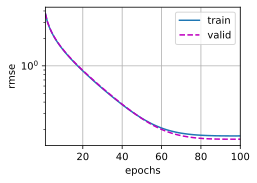

In [104]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,5,0,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f"{k}-折验证：平均训练log rmse: {float(train_l):f},平均验证log rmse:{float(valid_l):f}")